# Recherche d'Information - Projet

## MovieLens dataset

Binome : 
- **Ben Kabongo**
- **Sofia Borchani**

In [1]:
#! pip install --upgrade scikit-surprise

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
plt.style.use('seaborn-whitegrid')

### Chargement des données

In [5]:
# movies
# MovieID::Title::Genres
movies_df = pd.read_csv(
    '../data/ml-1m/movies.dat', 
    sep='::', 
    engine='python', 
    header=None, 
    names=['movie_ID', 'title', 'genres'],
    encoding='ISO-8859-1')

movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split('|'))

movies_df.sample(n=10).head(10)

,movie_ID,title,genres
2991,3060,"Commitments, The (1991)","[Comedy, Drama]"
1470,1502,Kissed (1996),[Romance]
861,872,Aiqing wansui (1994),[Drama]
2771,2840,Stigmata (1999),[Thriller]
1631,1677,Critical Care (1997),[Comedy]
2226,2295,"Impostors, The (1998)",[Comedy]
10,11,"American President, The (1995)","[Comedy, Drama, Romance]"
1314,1334,"Blob, The (1958)","[Horror, Sci-Fi]"
3860,3930,"Creature From the Black Lagoon, The (1954)",[Horror]
1237,1257,Better Off Dead... (1985),[Comedy]


In [6]:
# users
# UserID::Gender::Age::Occupation::Zip-code
users_df = pd.read_csv(
    '../data/ml-1m/users.dat', 
    sep='::', 
    engine='python', 
    header=None, 
    names=['user_ID', 'genre', 'age', 'occupation', 'zip_code'],
    encoding='ISO-8859-1')

users_df.sample(n=10).head(10)

,user_ID,genre,age,occupation,zip_code
4114,4115,M,25,15,99353
5956,5957,M,18,20,02038
5178,5179,M,25,12,94110
3024,3025,F,35,0,90004
2246,2247,M,45,2,60613
2673,2674,M,25,4,94110
1908,1909,M,18,4,89146
930,931,F,56,1,06032
5277,5278,F,25,7,55122
2408,2409,F,35,9,06074


In [7]:
# Rating
# UserID::MovieID::Rating::Timestamp
ratings_df = pd.read_csv(
    '../data/ml-1m/ratings.dat', 
    sep='::', 
    engine='python', 
    header=None, 
    names=['user_ID', 'movie_ID', 'rating', 'timestamp'],
    encoding='ISO-8859-1')

ratings_df.sample(n=10).head(10)

,user_ID,movie_ID,rating,timestamp
937363,5654,2628,3,958847019
967778,5833,3203,4,957880641
186407,1152,160,1,974868448
970209,5847,1391,4,957792263
624643,3778,2803,3,966050562
895496,5412,1249,4,994734542
626977,3792,1918,4,976802724
839458,5046,2917,4,962499168
449983,2774,3392,1,973098547
431907,2631,3545,4,973614457


## Statistiques

In [8]:
num_users  = ratings_df["user_ID"].nunique()
num_items  = ratings_df["movie_ID"].nunique()

print(f"there are {num_users} users and {num_items} items")

there are 6040 users and 3706 items


In [9]:
sparsity = (len(ratings_df)/(num_users*num_items)) * 100
print(f"Rating matrix is only {sparsity}% full")

Rating matrix is only 4.468362562231285% full


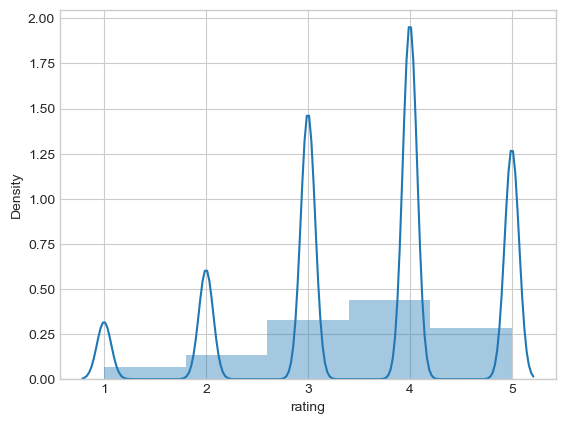

In [10]:
sns.distplot(ratings_df["rating"], bins=5)
plt.show()

## Tests : algorithmes de recommandation

In [11]:
from surprise import Dataset, Reader, SVD, KNNBaseline
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[["user_ID", "movie_ID", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.2)

In [12]:
algo1 = SVD()
algo1.fit(trainset)
movies = []
predictions1 = []
for movie in ratings_df["movie_ID"].unique():
    movies.append(movie)
    predictions1.append(algo1.predict(uid=None, iid=movie).est)

predictions1_df = pd.DataFrame()
predictions1_df['movie_ID'] = movies
predictions1_df['score'] = predictions1
predictions1_df = predictions1_df.sort_values(by='score', ascending=False)

In [13]:
algo2 = KNNBaseline()
algo2.fit(trainset)
predictions2 = []
for movie in ratings_df["movie_ID"].unique():
    predictions2.append(algo2.predict(uid=None, iid=movie).est)

predictions2_df = pd.DataFrame()
predictions2_df['movie_ID'] = movies
predictions2_df['score'] = predictions2
predictions2_df = predictions2_df.sort_values(by='score', ascending=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [14]:
np.mean(predictions1), np.mean(predictions2)

(3.4203636067177956, 3.4322381766231493)

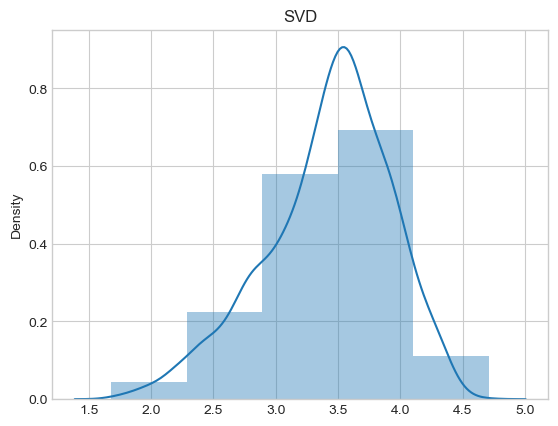

In [15]:
sns.distplot(predictions1, bins=5)
plt.title('SVD')
plt.show()

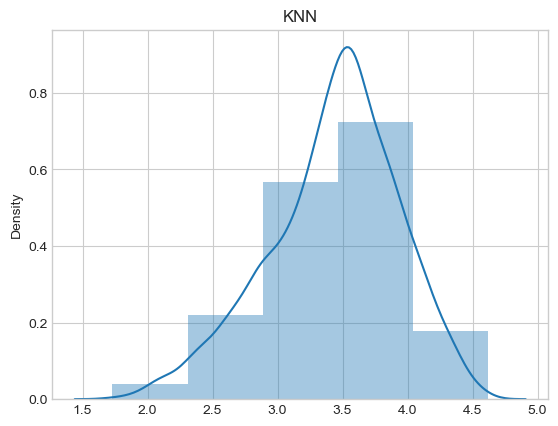

In [16]:
sns.distplot(predictions2, bins=5)
plt.title('KNN')
plt.show()

In [17]:
rel = ratings_df.groupby('movie_ID')['rating'].mean()
rel_dict = rel.to_dict()

In [18]:
predictions1_df['rel'] = predictions1_df['movie_ID'].map(rel_dict)
predictions2_df['rel'] = predictions2_df['movie_ID'].map(rel_dict)

In [19]:
predictions1_df["rang"] = predictions1_df["score"].rank(ascending=False).apply(int)
predictions2_df["rang"] = predictions2_df["score"].rank(ascending=False).apply(int)

In [20]:
seuil = 4
predictions1_df['bin'] = predictions1_df['rel'].apply(lambda x: 1 if x>=seuil else 0)
predictions2_df['bin'] = predictions2_df['rel'].apply(lambda x: 1 if x>=seuil else 0)
m = min(predictions1_df['bin'].sum(), predictions2_df['bin'].sum())
m

430

In [21]:
predictions1_df.head(10)

,movie_ID,score,rel,rang,bin
2617,2905,4.712081,4.608696,1,1
167,318,4.602083,4.554558,2,1
1092,2019,4.556804,4.560510,3,1
23,527,4.518546,4.510417,4,1
259,50,4.514687,4.517106,5,1
535,1148,4.513805,4.507937,6,1
629,904,4.471587,4.476190,7,1
669,858,4.455053,4.524966,8,1
29,745,4.453728,4.520548,9,1
1494,3022,4.441257,4.368932,10,1


In [22]:
predictions2_df.head(10)

,movie_ID,score,rel,rang,bin
2617,2905,4.617990,4.608696,1,1
167,318,4.596082,4.554558,2,1
1092,2019,4.595885,4.560510,3,1
669,858,4.572252,4.524966,4,1
535,1148,4.568623,4.507937,5,1
259,50,4.566144,4.517106,6,1
1449,922,4.551893,4.491489,7,1
23,527,4.546705,4.510417,8,1
29,745,4.542361,4.520548,9,1
629,904,4.536396,4.476190,10,1


## ECDF

In [23]:
ranking1 = np.array(predictions1_df[predictions1_df["bin"] == 1]['rang'])
ranking2 = np.array(predictions2_df[predictions2_df["bin"] == 1]['rang'])

In [24]:
len(ranking1), len(ranking2)

(430, 430)

In [25]:
def DCG(i):
    return 1 / np.log(i + 1)

def RBP(i, gamma):
    return gamma**(i-1)

In [26]:
diff_dcg = np.array(DCG(ranking1) - DCG(ranking2))
diff_rbp = np.array(RBP(ranking1, 0.5) - RBP(ranking2, 0.5))

215.49999999999997


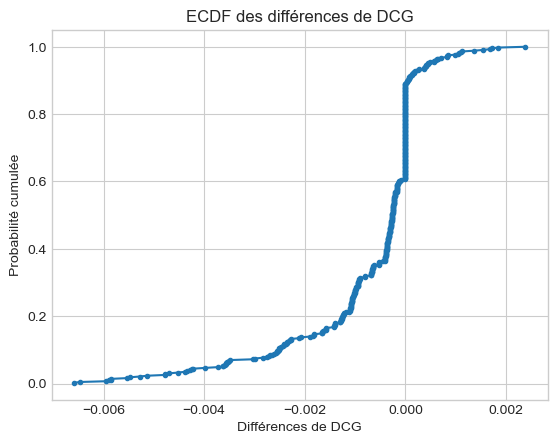

In [27]:
# calcul de l'ecdf
x_diff_dcg = np.sort(diff_dcg)
y_diff_dcg = np.arange(1, len(x_diff_dcg)+1) / len(x_diff_dcg)
print(y_diff_dcg.sum())

# tracé du graphique
plt.plot(x_diff_dcg, y_diff_dcg, marker='.', linestyle='solid')
plt.xlabel('Différences de DCG')
plt.ylabel('Probabilité cumulée')
plt.title('ECDF des différences de DCG')
plt.show()

215.49999999999997


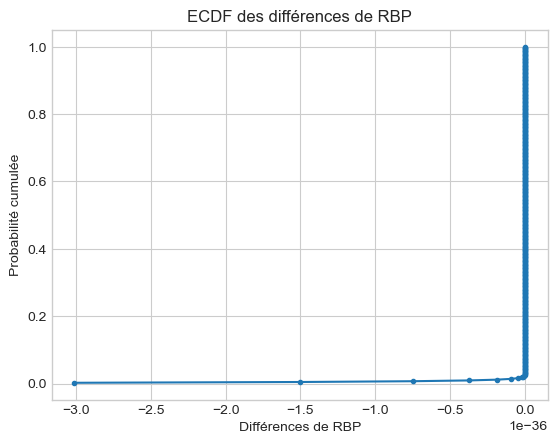

In [28]:

x_diff_rbp = np.sort(diff_rbp)

y_diff_rbp = np.arange(1, len(x_diff_rbp)+1) / (len(x_diff_rbp))
print(y_diff_rbp.sum())

plt.plot(x_diff_rbp, y_diff_rbp, marker='.', linestyle='solid')
plt.xlabel('Différences de RBP')
plt.ylabel('Probabilité cumulée')
plt.title('ECDF des différences de RBP')
plt.show()


215.49999999999997


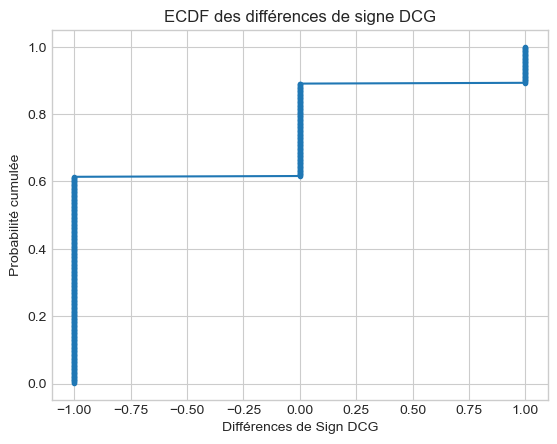

In [29]:
sign_dcg = np.sign(diff_dcg)
x_sign_dcg = np.sort(sign_dcg)

y_sign_dcg = np.arange(1, len(sign_dcg)+1) / (len(sign_dcg))
print(y_diff_dcg.sum())

plt.plot(x_sign_dcg, y_sign_dcg, marker='.', linestyle='solid')
plt.xlabel('Différences de Sign DCG')
plt.ylabel('Probabilité cumulée')
plt.title('ECDF des différences de signe DCG')
plt.show()

215.49999999999997


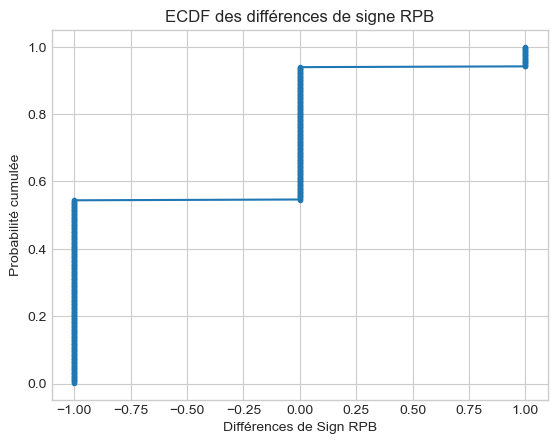

In [30]:
sign_rbp = np.sign(diff_rbp)
x_sign_rbp = np.sort(sign_rbp)

y_sign_rbp = np.arange(1, len(sign_rbp)+1) / (len(sign_rbp))
print(y_diff_rbp.sum())

plt.plot(x_sign_rbp, y_sign_rbp, marker='.', linestyle='solid')
plt.xlabel('Différences de Sign RPB')
plt.ylabel('Probabilité cumulée')
plt.title('ECDF des différences de signe RPB')
plt.show()

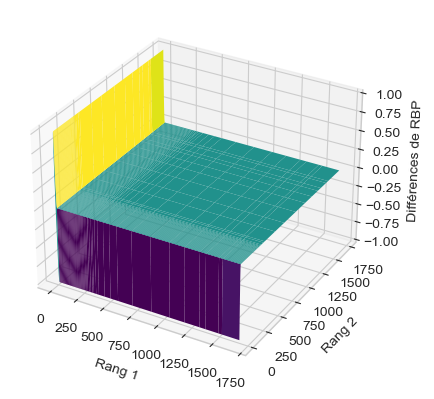

In [31]:
from mpl_toolkits.mplot3d import Axes3D

# Créer des grilles 2D
X, Y = np.meshgrid(ranking1, ranking2)

# Appliquer la fonction RBP() à chaque point de la grille pour obtenir la matrice 2D de z
Z = RBP(X, 0.5) - RBP(Y, 0.5)

# Créer la figure en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracer la surface
ax.plot_surface(X, Y, Z, cmap='viridis')

# Définir les labels des axes
ax.set_xlabel('Rang 1')
ax.set_ylabel('Rang 2')
ax.set_zlabel('Différences de RBP')

# Afficher la figure
plt.show()

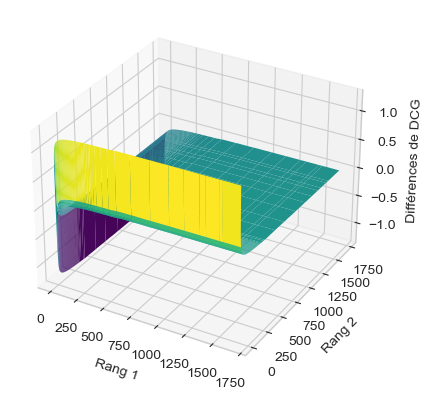

In [32]:
# Créer des grilles 2D
X, Y = np.meshgrid(ranking1, ranking2)

# Calculer les différences de scores DCG entre les deux classements
Z = DCG(ranking1)[:, np.newaxis] - DCG(ranking2)[np.newaxis, :]

# Créer la figure en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracer la surface
ax.plot_surface(X, Y, Z, cmap='viridis')

# Définir les labels des axes
ax.set_xlabel('Rang 1')
ax.set_ylabel('Rang 2')
ax.set_zlabel('Différences de DCG')

# Afficher la figure
plt.show()



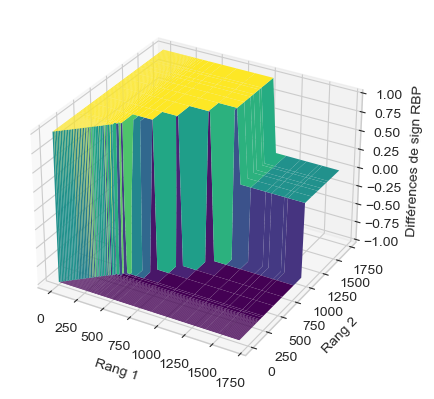

In [33]:
# Créer des grilles 2D
X, Y = np.meshgrid(ranking1, ranking2)

# Appliquer la fonction RBP() à chaque point de la grille pour obtenir la matrice 2D de z
Z = RBP(X, 0.5) - RBP(Y, 0.5)
Z = np.sign(Z)

# Créer la figure en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracer la surface
ax.plot_surface(X, Y, Z, cmap='viridis')

# Définir les labels des axes
ax.set_xlabel('Rang 1')
ax.set_ylabel('Rang 2')
ax.set_zlabel('Différences de sign RBP')

# Afficher la figure
plt.show()